## How to Maximize an Original Post's Retweet Count

by CaffeineOverflow.

### Context

Twitter, as an online social media platform, is a place where we relax ourselves, interact with others and know what’s happening around the world. Also, over the past few years, it has been a distinct social medium where the president of the United States communicates with the public. Thus it’s without doubt an indispensable part of many people’s daily life. Naturally, we’d like to figure out what one can do to make a tweet seen by more people and to gain more interactions, and thus to make oneself more influential. 

Here we mainly focus on **analyzing the factors that covary with the original post's retweet count**. In the original paper, they analyzed information diffusion at user and tweet level. *At the user level*, they emplyed multilevel generalized models for predicting retweetability and retweet count received by the original tweets. The results show us <u>the number of followers/ followees are positively associated with retweet count while the number of reciprocal ties are negatively correlated</u>. However, the results only tell us they are positively/negatively correlated. We still have little idea of how exactly are they correlated: for example, **is the retweet count linearly increase with the number of followers? Is there certain "threshold effect"?** Also, we are interested in **whether posting in English - an international language - helps in getting more retweet count**. If that is the case, one might choose to post in English! *At the tweet level*, they found that <u>the presence of hashtags is positively correlated and the presences of URLs and mentions are negatively correlated</u>. This is something interesting! It suggests posting with a hashtag! However, one might also be interested to know **when is the best to post**. A hint is suggested by the paper that <u>users are more active in weekdays than on weekends and during a day, 8pm is when the number of active users reach the peak</u>. Well, is it really that posts posted at 8pm get the most retweet count on average?

Let's explore together!

## The Data

**EgoTimelines**: The dataset contains ego users’ dynamic activities, including posting original tweets, retweeting, replying and @-mentioning. It also contains information about the number of retweets, presence of URLs and presence of hashtags for each tweet. The dataset is ideal to analyze the contributions of factors at the post level to the post’s influence.

**EgoAlterProfiles**: The dataset contains sampled users profiles, including the number of followers, languages, account created time, etc. Combined with the “retweet_count” term in EgoTimelines dataset we can analyze the effect of the number of followers and language (factors on the user level) on the post’s influence.

**EgoNetwork**: This dataset contains all pairs of ego-alter relationships, where the number of followees for each ego users can be calculated and further analyzed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Step1: read in relative dataset and preprocess

In [2]:
# it's a csv file with \t as the seperator
ego_profiles = pd.read_csv('./data/EgoAlterProfiles/EgoAlterProfiles.txt', sep="\t")
ego_profiles.head(3)

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False


In [3]:
# it's a csv file with \t as the seperator
ego_timeline = pd.read_csv('./data/EgoTimelines/EgoTimelines.txt', sep="\t",encoding='latin1')
ego_timeline.head(3)

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
0,NaN,NaN,398477318,249552537051598848,Sat Sep 22 16:55:35 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
1,NaN,NaN,398477318,249537963145433088,Sat Sep 22 15:57:41 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
2,NaN,NaN,398477318,129377372209299456,Thu Oct 27 02:02:23 +0000 2011,NaN,NaN,NaN,0,1,NaN,NaN,NaN


In [4]:
# it's a csv file with \t as the seperator
ego_networks = pd.read_csv('./data/EgoNetworks.txt', sep="\t")
ego_networks.head(3)

,egoID,followerID,followeeID
0,1,1,1573741
1,1,1,1662720
2,1,1,1968904


#### Preprocess0: filter out profiles of egos only

In [5]:
ego_profiles = ego_profiles[ego_profiles['IsEgo']]

#### Preprocess1: for each user, get the number of followees

(The number of followers/ reciprocal ties (friends) are already given in ego profiels.)

In [6]:
num_followee = ego_networks.groupby('followerID').size()
ego_profiles['followees_count'] = [num_followee[ego_id] if ego_id in num_followee else 0 for ego_id in ego_profiles['ID']]

In [7]:
ego_profiles.head(3)

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,followees_count
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False,28
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False,8
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False,0


### Step2: Analyze the factors at the user level

#### Step 2.1: Filter out the original tweets

Original tweets are statuses that are not replies or retweets.

In [8]:
# sanity check:
# see whether the numbers are consistent with the values given in supplementary information of paper
print('%d egos'%len(ego_timeline['egoID'].unique()))
print("%.3f: the proportion of replies"%(np.sum(ego_timeline['replyto_userid'].apply(lambda a: not math.isnan(a)))/ego_timeline.shape[0]))
print("%.3f: the proportion of retweets"%(np.sum(ego_timeline['retweeted_userid'].apply(lambda a: not math.isnan(a)))/ego_timeline.shape[0]))
    

17244 egos
0.241: the proportion of replies
0.224: the proportion of retweets


In [9]:
# filter out the original tweets
ego_original = ego_timeline[np.bitwise_and(ego_timeline['replyto_userid'].apply(lambda a: math.isnan(a)), 
                                             ego_timeline['retweeted_userid'].apply(lambda a: math.isnan(a)))]


#### Step 2.2: Group the original tweets by the egoID

In [21]:
# sanity check:
# whether these original tweets are sent by the egos in ego_profiles
ego_id = ego_profiles['ID']
for i in ego_timeline['egoID']:
      assert i in ego_id

In [10]:
tweeted_ego_id = ego_timeline['egoID'].unique()
originalTweeted_ego_id = ego_original['egoID'].unique()

In [11]:
# get the number of original posts for each ego
ego_numOriginal = ego_original.groupby('egoID').size()
# get the total number of retweet counts for each ego
ego_numRetweet = ego_original.groupby('egoID').median()['retweet_count']

In [12]:
# get the median number of retweet count for each ego
ego_profiles['tweeted'] = [ego_id in tweeted_ego_id for ego_id in ego_profiles['ID']]
ego_profiles['originalTweeted'] = [ego_id in originalTweeted_ego_id for ego_id in ego_profiles['ID']]
ego_profiles['numOriginal'] = [ego_numOriginal[ego_id] if ego_id in originalTweeted_ego_id else 0 for ego_id in ego_profiles['ID']]
ego_profiles['medianRetweet'] = [ego_numRetweet[ego_id] if ego_id in originalTweeted_ego_id else 0 for ego_id in ego_profiles['ID']]

#### Step 2.3: Plot the number of averaged retweet count as a function of the number of followers/ followees/ friends

In [14]:
# In case fake accounts may influence the results, we deleted those users who have not posted anything.
ego_tweeted_profiles = ego_profiles[ego_profiles['tweeted']]

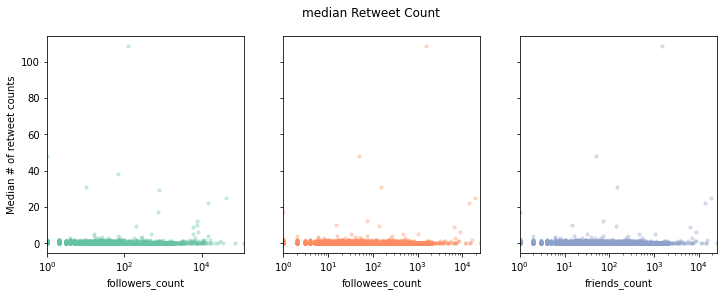

In [160]:
features = ['followers_count', 'followees_count', 'friends_count']
colors_features = sns.color_palette("Set2").as_hex()[:len(features)]

fig, ax = plt.subplots(1,3,figsize=(12,4),sharey=True)
for axi, key in zip(range(3), features):
    ax[axi].scatter(ego_tweeted_profiles[key], ego_tweeted_profiles['medianRetweet'],s=10,alpha=0.3, c=colors_features[axi])
    ax[axi].set_xscale('log') # because values are skewed, we use log here
    ax[axi].set_xlim([1,np.max(ego_tweeted_profiles[key])]) 
    ax[axi].set_xlabel(key)
    
ax[0].set_ylabel('Median # of retweet counts')
plt.suptitle('median Retweet Count')
plt.show()

First we noticed that the average numbers of retweet count are not very large: mostly are below 10, some are more than 20. Further we seperated egos into super influencers and normal users according to the average number of retweet counts and analyze seperately.

In [48]:
# seperated egos into super influencers and normal users according to the average number of retweet counts 
super_influencer = ego_tweeted_profiles[ego_tweeted_profiles['medianRetweet'] >= 20]
normal_user = ego_tweeted_profiles[ego_tweeted_profiles['medianRetweet'] < 20]

In [200]:
super_influencer[['ID','followers_count','followees_count','friends_count','numOriginal','medianRetweet']]

,ID,followers_count,followees_count,friends_count,numOriginal,medianRetweet
4325,4326,67.0,0,0,6,38.0
16359,16360,126.0,1498,1500,1,109.0
17158,17159,1.0,50,50,11,48.0
17821,17822,10.0,151,150,1,31.0
18669,18670,42342.0,0,18915,1349,25.0
26428,26429,776.0,0,0,232,29.5
32949,32950,14954.0,0,13777,29,22.0


Here two users actually draw our attention: 1. user 18670, who seems to be a famous person as she has lots of followers; 2. user 17159 - a user just like us! - with only one follower. But how come does she make it to have so many retweets?

/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



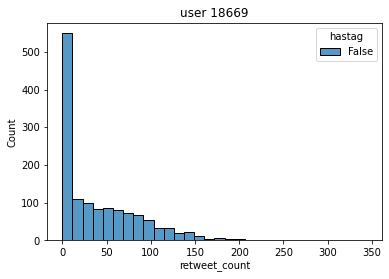

In [153]:
# examine 18670
user18670 = ego_original[ego_original['egoID']==18670]
user18670['hastag'] = user18670.loc[:,'hashtags'].apply(lambda hashtag: not (type(hashtag)==float and math.isnan(hashtag)))
sns.histplot(data=user18670, x='retweet_count', hue="hastag", multiple="stack")
plt.title('user 18669')
plt.show()

/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



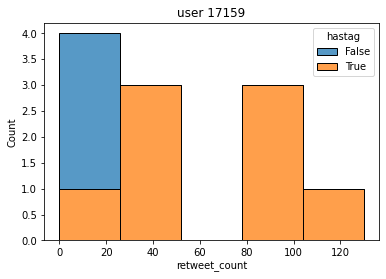

In [154]:
# examine 17159
user17159 = ego_original[ego_original['egoID']==17159]
user17159['hastag'] = user17159.loc[:,'hashtags'].apply(lambda hashtag: not (type(hashtag)==float and math.isnan(hashtag)))
sns.histplot(data=user17159, x='retweet_count', hue="hastag", multiple="stack")
plt.title('user 17159')
plt.show()

From above analysis, we realize that, if you already have many followers, you might not need to do much to get retweets; but if you do not, just like user 17159, **it's a smart choice to post with hashtags**, which will make your posts seen by more!

Now for the normal users, to exclude the effects of hashtags (and also urls, mentions as they are shown to have certain effects in the original paper), we consider only the original posts with aimple plain texts.

In [42]:
# filter out the original posts with aimple plain texts.
ego_original['simpleText'] = ego_original.apply(lambda y: 
                                                    type(y['hashtags'])==float and math.isnan(y['hashtags'])
                                                    and type(y['urls'])==float and math.isnan(y['urls'])
                                                    and type(y['mentions_ids'])==float and math.isnan(y['mentions_ids'])
                                                ,axis=1)

/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
ego_numRetweet_simple = ego_original[ego_original['simpleText']].groupby('egoID').median()['retweet_count']
# whether one has posted a simple plain tweet
normal_user['tweeted_simple'] = [ego_id in ego_numRetweet_simple for ego_id in normal_user['ID']] 
# median of the retweet count of one's simple posts
normal_user['medianRetweet_simple'] = [ego_numRetweet_simple[ego_id] if ego_id in ego_numRetweet_simple else 0 for ego_id in normal_user['ID']]


/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
normal_user_with_simple_posts = normal_user[normal_user['tweeted_simple']]

/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

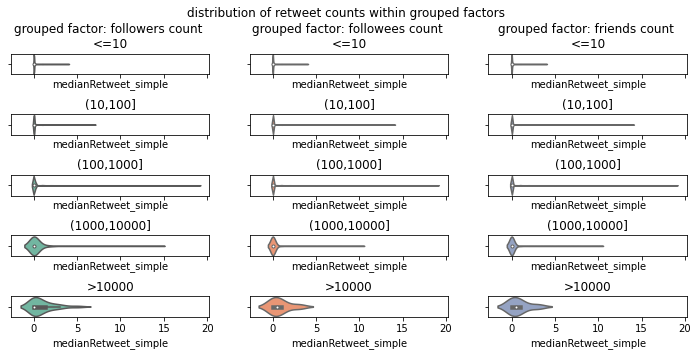

In [157]:
def _group(n):
    if n == 0 or n == 1:
        return 1
    return np.ceil(np.log10(n))
    
    
# we group followers/ followees/ friends count with certain defined intervals
normal_user_with_simple_posts['followers_count_group'] = normal_user_with_simple_posts['followers_count'].apply(_group)
normal_user_with_simple_posts['followees_count_group'] = normal_user_with_simple_posts['followees_count'].apply(_group)
normal_user_with_simple_posts['friends_count_group'] = normal_user_with_simple_posts['friends_count'].apply(_group)

# plot the histogram of the distribution of retweet count for each interval
figure,ax = plt.subplots(5,3,figsize=(10,5),sharex=True, sharey=True)
color = sns.color_palette("tab10")
group_name = ['<=10', '(10,100]', '(100,1000]','(1000,10000]','>10000']
for groupi in range(5):
#     for fi, feature in enumerate(features):
    sns.violinplot(x=normal_user_with_simple_posts[normal_user_with_simple_posts['followers_count_group']==groupi+1]['medianRetweet_simple'],
            color=colors_features[0], ax = ax[groupi][0])
    sns.violinplot(x=normal_user_with_simple_posts[normal_user_with_simple_posts['followees_count_group']==groupi+1]['medianRetweet_simple'],
            color=colors_features[1], ax = ax[groupi][1])
    sns.violinplot(x=normal_user_with_simple_posts[normal_user_with_simple_posts['friends_count_group']==groupi+1]['medianRetweet_simple'],
            color=colors_features[2], ax = ax[groupi][2])

    if groupi == 0:
        ax[groupi][0].set_title('grouped factor: followers count \n'+group_name[groupi])
        ax[groupi][1].set_title('grouped factor: followees count \n'+group_name[groupi])
        ax[groupi][2].set_title('grouped factor: friends count \n'+group_name[groupi])
    else:
        for ci in range(3):
            ax[groupi][ci].set_title(group_name[groupi])
plt.tight_layout()
plt.suptitle('distribution of retweet counts within grouped factors')
plt.subplots_adjust(top=0.85)
plt.show()

We noticed that as the followers/followees/friends counts increases (from the first row to the fifth row) the probability of receiving more retweets increases (the plot gets "fatter"). **Especially when number reaches three digits the effect starts to become significant.**

We admit that there might be strong multicollinearity among these factors, as shown in the next plot - especially between the number of followers and the number of friends. But our conclusion remains the same: By following more people, being more interactive (getting more friends), the user can hopefully get more followers and more retweets. When the figure reaches two digits from one digit, the user might not see much increase in terms of retweet count of a plain post, but once one has made it to three figures, he can expect to see some significant changes. 

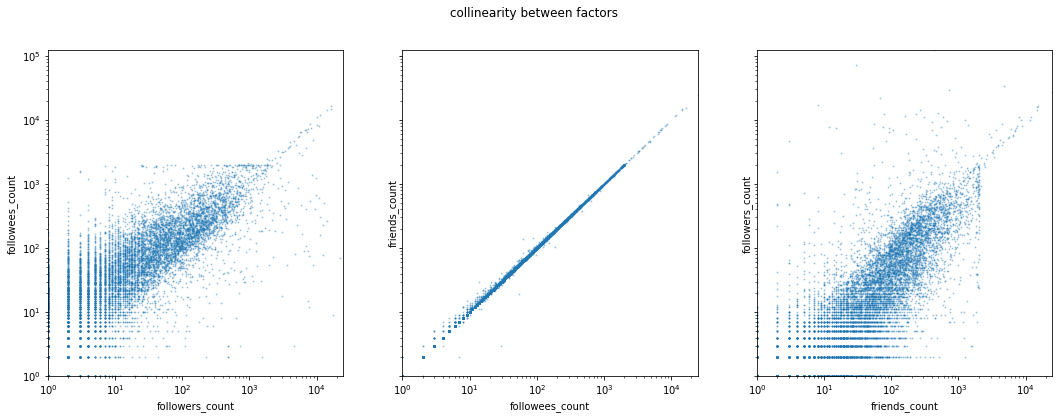

In [158]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18,6))
axi = 0 # which axes
for xlabel, ylabel in zip(['followers_count','followees_count','friends_count'],['followees_count','friends_count','followers_count']):
    ax[axi].scatter(normal_user_with_simple_posts[xlabel], normal_user_with_simple_posts[ylabel], s=1,alpha=0.3)
    ax[axi].set_xscale('log') # same as above, we use log as the values are skewed
    ax[axi].set_xlabel(xlabel)
    ax[axi].set_xlim([1,np.max(normal_user_with_simple_posts[xlabel])]) # constrain on x limit
    ax[axi].set_yscale('log') # same as above, we use log as the values are skewed
    ax[axi].set_ylabel(ylabel)
    ax[axi].set_ylim([1,np.max(normal_user_with_simple_posts[ylabel])]) # constrain on y limit
    axi += 1
plt.suptitle('collinearity between factors')
plt.show()
    

#### Step 2.3: English/ non English; matching

We further attempt to study the impact of language by considering language='en' (english) as our "treatment".

In [82]:
super_influencer[['lang','ID','followers_count','followees_count','friends_count','numOriginal','medianRetweet']]

,lang,ID,followers_count,followees_count,friends_count,numOriginal,medianRetweet
4325,id,4326,67.0,0,0,6,38.0
16359,en,16360,126.0,1498,1500,1,109.0
17158,th,17159,1.0,50,50,11,48.0
17821,en,17822,10.0,151,150,1,31.0
18669,en,18670,42342.0,18890,18915,1349,25.0
26428,en,26429,776.0,0,0,232,29.5
32949,es,32950,14954.0,14201,13777,29,22.0


First we noticed, for the super influencer, there are both english and non-english speakers.

Then we create a regressor that predicts median retweet counts for each user.

In [84]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

normal_user_with_simple_posts['english'] = normal_user['lang'].apply(lambda lang: int(lang=='en'))
mod = smf.ols(formula='medianRetweet_simple ~ followers_count + followees_count + friends_count + statuses_count + C(english) ',
                   data=normal_user_with_simple_posts)
res = mod.fit()

/Users/wsq/opt/anaconda2/envs/CS456/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     medianRetweet_simple   R-squared:                       0.020
Model:                              OLS   Adj. R-squared:                  0.019
Method:                   Least Squares   F-statistic:                     52.59
Date:                  Tue, 08 Dec 2020   Prob (F-statistic):           3.27e-54
Time:                          15:50:37   Log-Likelihood:                -4402.8
No. Observations:                 13009   AIC:                             8818.
Df Residuals:                     13003   BIC:                             8862.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.

Coefficient for 'english' can be interpreted as the difference in the predicted value in decision for each one-unit difference in 'english' if other independent variables remain constant. Since 'english' is a categorical variable coded as 0 or 1, a one unit difference represents switching from one category to the other. So compared to users that do not speak English, we would expect English speakers to decrease the retweet count by 0.04. However this coefficient has a p value of 0.968, which is absolutely not statiscally significant. The result suggests posting in an international language or not like English will not affect the retweet count significantly. (Here we assume that 

So far we've studied this question very grossly, next we are going to examine more closely: things might be different for each language specifically as different population might have different habit of usage.

In [163]:
import warnings
warnings.filterwarnings("ignore")

In [164]:
normal_user["lang_normalized"]=normal_user["lang"].apply(lambda x:str(x).split("-")[0])

In [184]:
data_lang=normal_user[["lang_normalized","followers_count","friends_count","statuses_count", "followees_count","medianRetweet"]].groupby("lang_normalized").mean()
data_lang=data_lang[normal_user['lang_normalized'].value_counts()>100]

In [185]:
data_lang.reset_index(inplace=True)
data_lang['lang_readable']=['Arabic','German','English','Spanish','Franch','Indonesian','Italian','Japanese','Korean','Dutch','Portuguese','Russian','Turkish']

In [186]:
data_lang

,lang_normalized,followers_count,friends_count,statuses_count,followees_count,medianRetweet,lang_readable
0,ar,211.878505,194.623498,803.088117,193.311081,0.058745,Arabic
1,de,101.870968,150.225806,175.206452,150.600000,0.019355,German
2,en,106.940069,107.038304,705.102970,106.847321,0.029159,English
3,es,72.689796,122.801633,577.271429,122.566531,0.029796,Spanish
4,fr,52.528037,78.121495,441.957944,77.766355,0.021028,Franch
5,id,58.253359,89.600768,644.166987,89.345489,0.025912,Indonesian
6,it,37.542857,79.690476,310.280952,79.342857,0.028571,Italian
7,ja,105.637848,123.972142,2705.913545,123.537944,0.047550,Japanese
8,ko,23.278049,47.878049,254.770732,47.800000,0.017073,Korean
9,nl,63.635514,84.560748,1297.570093,84.364486,0.051402,Dutch


In [192]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = data_lang['lang_readable'].values
for col in ['medianRetweet','followers_count']:
    data_lang[col+'_rounded'] = round(data_lang[col],2)
    

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=data_lang['medianRetweet_rounded'], name="Averaged median retweet count"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=data_lang['followers_count_rounded'], name="Averaged followers count"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name",textinfo='value')

fig.update_layout(
    title_text="averaged retweet count and followers count of different language speakers",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='retweets', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='followers', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

Looking at the user language data, we can recognize some patterns in terms of the correlation between user language and user activeness in terms of retweeting. In particular, we can categorize the countries into 3 categories:

The fanatics: Arabic speakers have the highest average number of followers count, and they also have the highest retweets frequency among all langauge user groups.

The actives: Dutch speaker, and japanese speakers share a common point: they more like to retweet even though they don’t necessarily have a high number of followers count. Which may be explained as they really focus on their favorite followers and keep interacting with them rather than follow many people but remain inactive. Therefore, **if you are Dutch or Japanese speaker, we would suggest you to posting in these languages as your post might get a higher chance of being retweeted by your people!**

The silent group: Russian speaker and German speakers are the exact opposite of the previous category. Russian speakers and German speakers they have a high average follower count, which means they are active on this social media. But in the same time they have a low retweet frequqncy, which could be explained as they are more cautious about retweeting what others say. Therefore, **if you are Russian or German speaker, you might like to post in English to change your audiances to those who are more willing to retweet.** :P